In [39]:
# !pip install gymnasium[toy-text]

GIF saved as blackjack.gif


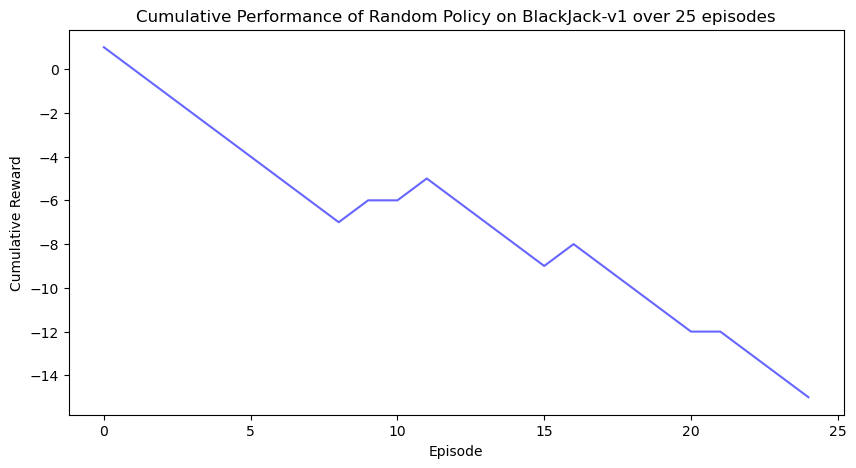

In [1]:
import gymnasium as gym
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import imageio
import matplotlib.pyplot as plt
import re

# Initialize the Blackjack environment
env = gym.make('Blackjack-v1', natural=False, sab=False, render_mode='rgb_array')

def render_to_image(env):
    """Convert the text-based rendering to an image."""
    img = env.render()
    return img

def number_to_words(number):
    return number
    # Define a dictionary to map numerical values to words
    num_to_words = {
        1: "One", 2: "Two", 3: "Three", 4: "Four", 5: "Five",
        6: "Six", 7: "Seven", 8: "Eight", 9: "Nine", 10: "Ten",
        11: "Eleven", 12: "Twelve", 13: "Thirteen", 14: "Fourteen", 15: "Fifteen",
        16: "Sixteen", 17: "Seventeen", 18: "Eighteen", 19: "Nineteen", 20: "Twenty"
    }

    if number in num_to_words:
        return num_to_words[number]
    elif number > 20 and number <= 30:
        return "Twenty " + num_to_words[number - 20]
    else:
        return str(number)  # Use the numerical value as a string if not found in the dictionary

def generate_prompt(observation, player_cards_count=2, init=False):
    if not init:
        player_sum, dealer_card, usable_ace = observation
    else:
        player_sum, dealer_card, usable_ace = observation[0]
        
    # Checking for usable ace
    if usable_ace:
        ace_status = "You have a usable Ace."
    else:
        ace_status = ""

    context = "In a a game of blackjack\n"
    dealer_situation = (f"The dealer has one card showing and one card hidden. "
                        f"The visible card is a {number_to_words(dealer_card)}.")
    player_situation = (f"\nI have {number_to_words(player_cards_count)} cards whose sum is {number_to_words(player_sum)}. {ace_status} ")

    question = "\nGiven we win close to 21 and lose badly at anything above it (going above 21 should be avoided), Do I hit or stand, hit will lead to drawing one card at random and increasing the total, stand will keep the same total?\n  The first line of your answer should be 'Hit.' or 'Stand.' The second line should be the justification."

    prompt = context + dealer_situation + "\n" + player_situation + question

    return prompt

def process_llm_response(llm_response):
    # print(llm_response)
    # Split the response into lines
    lines = llm_response.strip().split('\n')

    # Extract the first line, which contains the suggested action
    action_line = lines[0].split('.')[0]

    # Extract the suggested action (it should be the last word in the line)
    suggested_action = action_line.split()[-1]

    # Convert the suggested action into a valid action for Blackjack
    if suggested_action.lower() == 'hit':
        action = 1  # Action for "hit" in Blackjack
    elif suggested_action.lower() == 'stand':
        action = 0  # Action for "stand" in Blackjack
    else:
        print("uninterpretable:" + llm_response)
        # If the suggested action is not recognized, default to "hit"
        action = 1

    return action

def extract_decision_llama2(text):
    hit_search = re.search(r"\bHit\b", text)
    stand_search = re.search(r"\bStand\b", text)
    
    if hit_search:
        return 1
    elif stand_search:
        return 0
    else:
        return 0
 


def evaluate_and_save_gif(num_episodes=100, filename="blackjack.gif"):
    """
    Evaluate a random policy, save the rendered outputs to a GIF, and return aggregated rewards.
    """
    frames = []
    rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        # print(generate_prompt(state, init=True))
        episode_reward = 0
        done = False

        # Add initial state to frames
        frames.append(render_to_image(env))

        while not done:
            
            
            # Choose a random action
            action = env.action_space.sample()
            
            
            # Take a step in the environment
            next_state, reward, done, _, info = env.step(action)
            # print(generate_prompt(next_state))
            
            episode_reward += reward

            # Add the new state to frames
            frames.append(render_to_image(env))

        rewards.append(episode_reward)

    # Save frames as a gif
    imageio.mimsave(filename, [np.array(f) for f in frames], duration=0.5)
    print(f"GIF saved as {filename}")

    return rewards

# Evaluate the random policy, save the GIF, and retrieve rewards
num_episodes = 25
rewards = evaluate_and_save_gif(num_episodes=num_episodes, filename="blackjack.gif")

# Calculate cumulative rewards
cumulative_rewards = np.cumsum(rewards)

# Plotting the cumulative rewards
plt.figure(figsize=(10, 5))
plt.plot(np.arange(num_episodes), cumulative_rewards, alpha=0.6, color='blue')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Performance of Random Policy on BlackJack-v1 over {} episodes'.format(num_episodes))
plt.show()


In [3]:
import os
import openai

openai.api_base = "http://localhost:1234/v1" # point to the local server
openai.api_key = "" # no need for an API key

# completion = openai.ChatCompletion.create(
#   model="local-model", # this field is currently unused
#   messages=[
#     {"role": "system", "content": "Always answer in rhymes."},
#     {"role": "user", "content": "Introduce yourself."}
#   ]
# )

# print(completion.choices[0].message)

In [4]:
# !pip install tqdm

  4%|███▎                                                                               | 1/25 [00:32<13:01, 32.57s/it]

In a a game of blackjack
The dealer has one card showing and one card hidden. The visible card is a 10.

I have 2 cards whose sum is 21. You have a usable Ace. 
Given we win close to 21 and lose badly at anything above it (going above 21 should be avoided), Do I hit or stand, hit will lead to drawing one card at random and increasing the total, stand will keep the same total?
  The first line of your answer should be 'Hit.' or 'Stand.' The second line should be the justification.
action: 0
action: 0


  8%|██████▋                                                                            | 2/25 [01:16<15:05, 39.37s/it]

In a a game of blackjack
The dealer has one card showing and one card hidden. The visible card is a 2.

I have 2 cards whose sum is 12.  
Given we win close to 21 and lose badly at anything above it (going above 21 should be avoided), Do I hit or stand, hit will lead to drawing one card at random and increasing the total, stand will keep the same total?
  The first line of your answer should be 'Hit.' or 'Stand.' The second line should be the justification.
action: 0
action: 0


 12%|█████████▉                                                                         | 3/25 [01:41<12:03, 32.89s/it]

In a a game of blackjack
The dealer has one card showing and one card hidden. The visible card is a 10.

I have 2 cards whose sum is 19.  
Given we win close to 21 and lose badly at anything above it (going above 21 should be avoided), Do I hit or stand, hit will lead to drawing one card at random and increasing the total, stand will keep the same total?
  The first line of your answer should be 'Hit.' or 'Stand.' The second line should be the justification.
action: 0
action: 0


 16%|█████████████▎                                                                     | 4/25 [02:17<11:52, 33.94s/it]

In a a game of blackjack
The dealer has one card showing and one card hidden. The visible card is a 8.

I have 2 cards whose sum is 12.  
Given we win close to 21 and lose badly at anything above it (going above 21 should be avoided), Do I hit or stand, hit will lead to drawing one card at random and increasing the total, stand will keep the same total?
  The first line of your answer should be 'Hit.' or 'Stand.' The second line should be the justification.
action: 0
action: 0


 20%|████████████████▌                                                                  | 5/25 [02:39<09:55, 29.75s/it]

In a a game of blackjack
The dealer has one card showing and one card hidden. The visible card is a 4.

I have 2 cards whose sum is 17.  
Given we win close to 21 and lose badly at anything above it (going above 21 should be avoided), Do I hit or stand, hit will lead to drawing one card at random and increasing the total, stand will keep the same total?
  The first line of your answer should be 'Hit.' or 'Stand.' The second line should be the justification.
action: 0
action: 0


 24%|███████████████████▉                                                               | 6/25 [03:26<11:17, 35.67s/it]

In a a game of blackjack
The dealer has one card showing and one card hidden. The visible card is a 3.

I have 2 cards whose sum is 18. You have a usable Ace. 
Given we win close to 21 and lose badly at anything above it (going above 21 should be avoided), Do I hit or stand, hit will lead to drawing one card at random and increasing the total, stand will keep the same total?
  The first line of your answer should be 'Hit.' or 'Stand.' The second line should be the justification.
action: 0
action: 0


 28%|███████████████████████▏                                                           | 7/25 [03:48<09:16, 30.94s/it]

In a a game of blackjack
The dealer has one card showing and one card hidden. The visible card is a 1.

I have 2 cards whose sum is 17.  
Given we win close to 21 and lose badly at anything above it (going above 21 should be avoided), Do I hit or stand, hit will lead to drawing one card at random and increasing the total, stand will keep the same total?
  The first line of your answer should be 'Hit.' or 'Stand.' The second line should be the justification.
action: 1
action: 1


 32%|██████████████████████████▌                                                        | 8/25 [04:16<08:32, 30.14s/it]

In a a game of blackjack
The dealer has one card showing and one card hidden. The visible card is a 10.

I have 2 cards whose sum is 20.  
Given we win close to 21 and lose badly at anything above it (going above 21 should be avoided), Do I hit or stand, hit will lead to drawing one card at random and increasing the total, stand will keep the same total?
  The first line of your answer should be 'Hit.' or 'Stand.' The second line should be the justification.
action: 0
action: 0


 36%|█████████████████████████████▉                                                     | 9/25 [04:44<07:49, 29.36s/it]

In a a game of blackjack
The dealer has one card showing and one card hidden. The visible card is a 5.

I have 2 cards whose sum is 19.  
Given we win close to 21 and lose badly at anything above it (going above 21 should be avoided), Do I hit or stand, hit will lead to drawing one card at random and increasing the total, stand will keep the same total?
  The first line of your answer should be 'Hit.' or 'Stand.' The second line should be the justification.
action: 0
action: 0


 40%|████████████████████████████████▊                                                 | 10/25 [05:22<08:00, 32.03s/it]

In a a game of blackjack
The dealer has one card showing and one card hidden. The visible card is a 2.

I have 2 cards whose sum is 20.  
Given we win close to 21 and lose badly at anything above it (going above 21 should be avoided), Do I hit or stand, hit will lead to drawing one card at random and increasing the total, stand will keep the same total?
  The first line of your answer should be 'Hit.' or 'Stand.' The second line should be the justification.
action: 0
action: 0


 44%|████████████████████████████████████                                              | 11/25 [06:07<08:24, 36.00s/it]

In a a game of blackjack
The dealer has one card showing and one card hidden. The visible card is a 10.

I have 2 cards whose sum is 16.  
Given we win close to 21 and lose badly at anything above it (going above 21 should be avoided), Do I hit or stand, hit will lead to drawing one card at random and increasing the total, stand will keep the same total?
  The first line of your answer should be 'Hit.' or 'Stand.' The second line should be the justification.
action: 0
action: 0


 48%|███████████████████████████████████████▎                                          | 12/25 [06:41<07:41, 35.50s/it]

In a a game of blackjack
The dealer has one card showing and one card hidden. The visible card is a 10.

I have 2 cards whose sum is 17.  
Given we win close to 21 and lose badly at anything above it (going above 21 should be avoided), Do I hit or stand, hit will lead to drawing one card at random and increasing the total, stand will keep the same total?
  The first line of your answer should be 'Hit.' or 'Stand.' The second line should be the justification.
action: 1
action: 1


 52%|██████████████████████████████████████████▋                                       | 13/25 [07:29<07:51, 39.26s/it]

In a a game of blackjack
The dealer has one card showing and one card hidden. The visible card is a 2.

I have 2 cards whose sum is 13.  
Given we win close to 21 and lose badly at anything above it (going above 21 should be avoided), Do I hit or stand, hit will lead to drawing one card at random and increasing the total, stand will keep the same total?
  The first line of your answer should be 'Hit.' or 'Stand.' The second line should be the justification.
action: 0
action: 0


 56%|█████████████████████████████████████████████▉                                    | 14/25 [08:36<08:43, 47.62s/it]

In a a game of blackjack
The dealer has one card showing and one card hidden. The visible card is a 5.

I have 2 cards whose sum is 15.  
Given we win close to 21 and lose badly at anything above it (going above 21 should be avoided), Do I hit or stand, hit will lead to drawing one card at random and increasing the total, stand will keep the same total?
  The first line of your answer should be 'Hit.' or 'Stand.' The second line should be the justification.
action: 1
action: 1


 60%|█████████████████████████████████████████████████▏                                | 15/25 [09:04<06:56, 41.67s/it]

In a a game of blackjack
The dealer has one card showing and one card hidden. The visible card is a 7.

I have 2 cards whose sum is 12.  
Given we win close to 21 and lose badly at anything above it (going above 21 should be avoided), Do I hit or stand, hit will lead to drawing one card at random and increasing the total, stand will keep the same total?
  The first line of your answer should be 'Hit.' or 'Stand.' The second line should be the justification.
action: 0
action: 0
In a a game of blackjack
The dealer has one card showing and one card hidden. The visible card is a 8.

I have 2 cards whose sum is 13.  
Given we win close to 21 and lose badly at anything above it (going above 21 should be avoided), Do I hit or stand, hit will lead to drawing one card at random and increasing the total, stand will keep the same total?
  The first line of your answer should be 'Hit.' or 'Stand.' The second line should be the justification.
action: 1


 64%|████████████████████████████████████████████████████▍                             | 16/25 [10:19<07:46, 51.78s/it]

In a a game of blackjack
The dealer has one card showing and one card hidden. The visible card is a 8.

I have 3 cards whose sum is 15.  
Given we win close to 21 and lose badly at anything above it (going above 21 should be avoided), Do I hit or stand, hit will lead to drawing one card at random and increasing the total, stand will keep the same total?
  The first line of your answer should be 'Hit.' or 'Stand.' The second line should be the justification.
action: 0
action: 0


 68%|███████████████████████████████████████████████████████▊                          | 17/25 [10:55<06:15, 46.95s/it]

In a a game of blackjack
The dealer has one card showing and one card hidden. The visible card is a 10.

I have 2 cards whose sum is 15. You have a usable Ace. 
Given we win close to 21 and lose badly at anything above it (going above 21 should be avoided), Do I hit or stand, hit will lead to drawing one card at random and increasing the total, stand will keep the same total?
  The first line of your answer should be 'Hit.' or 'Stand.' The second line should be the justification.
action: 0
action: 0


 72%|███████████████████████████████████████████████████████████                       | 18/25 [11:36<05:16, 45.16s/it]

In a a game of blackjack
The dealer has one card showing and one card hidden. The visible card is a 10.

I have 2 cards whose sum is 15.  
Given we win close to 21 and lose badly at anything above it (going above 21 should be avoided), Do I hit or stand, hit will lead to drawing one card at random and increasing the total, stand will keep the same total?
  The first line of your answer should be 'Hit.' or 'Stand.' The second line should be the justification.
action: 0
action: 0


 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [12:15<04:19, 43.26s/it]

In a a game of blackjack
The dealer has one card showing and one card hidden. The visible card is a 10.

I have 2 cards whose sum is 15. You have a usable Ace. 
Given we win close to 21 and lose badly at anything above it (going above 21 should be avoided), Do I hit or stand, hit will lead to drawing one card at random and increasing the total, stand will keep the same total?
  The first line of your answer should be 'Hit.' or 'Stand.' The second line should be the justification.
action: 0
action: 0


 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [12:54<03:30, 42.14s/it]

In a a game of blackjack
The dealer has one card showing and one card hidden. The visible card is a 1.

I have 2 cards whose sum is 16.  
Given we win close to 21 and lose badly at anything above it (going above 21 should be avoided), Do I hit or stand, hit will lead to drawing one card at random and increasing the total, stand will keep the same total?
  The first line of your answer should be 'Hit.' or 'Stand.' The second line should be the justification.
action: 1
action: 1


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [13:36<02:48, 42.01s/it]

In a a game of blackjack
The dealer has one card showing and one card hidden. The visible card is a 1.

I have 2 cards whose sum is 13. You have a usable Ace. 
Given we win close to 21 and lose badly at anything above it (going above 21 should be avoided), Do I hit or stand, hit will lead to drawing one card at random and increasing the total, stand will keep the same total?
  The first line of your answer should be 'Hit.' or 'Stand.' The second line should be the justification.
action: 0
action: 0


 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [14:36<02:22, 47.46s/it]

In a a game of blackjack
The dealer has one card showing and one card hidden. The visible card is a 10.

I have 2 cards whose sum is 5.  
Given we win close to 21 and lose badly at anything above it (going above 21 should be avoided), Do I hit or stand, hit will lead to drawing one card at random and increasing the total, stand will keep the same total?
  The first line of your answer should be 'Hit.' or 'Stand.' The second line should be the justification.
action: 0
action: 0


 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [15:31<01:39, 49.74s/it]

In a a game of blackjack
The dealer has one card showing and one card hidden. The visible card is a 9.

I have 2 cards whose sum is 10.  
Given we win close to 21 and lose badly at anything above it (going above 21 should be avoided), Do I hit or stand, hit will lead to drawing one card at random and increasing the total, stand will keep the same total?
  The first line of your answer should be 'Hit.' or 'Stand.' The second line should be the justification.
action: 0
action: 0


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [16:05<00:44, 44.99s/it]

In a a game of blackjack
The dealer has one card showing and one card hidden. The visible card is a 3.

I have 2 cards whose sum is 8.  
Given we win close to 21 and lose badly at anything above it (going above 21 should be avoided), Do I hit or stand, hit will lead to drawing one card at random and increasing the total, stand will keep the same total?
  The first line of your answer should be 'Hit.' or 'Stand.' The second line should be the justification.
action: 0
action: 0


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [16:33<00:00, 39.74s/it]

In a a game of blackjack
The dealer has one card showing and one card hidden. The visible card is a 10.

I have 2 cards whose sum is 11.  
Given we win close to 21 and lose badly at anything above it (going above 21 should be avoided), Do I hit or stand, hit will lead to drawing one card at random and increasing the total, stand will keep the same total?
  The first line of your answer should be 'Hit.' or 'Stand.' The second line should be the justification.
action: 0
action: 0


GIF saved as blackjackllm.gif


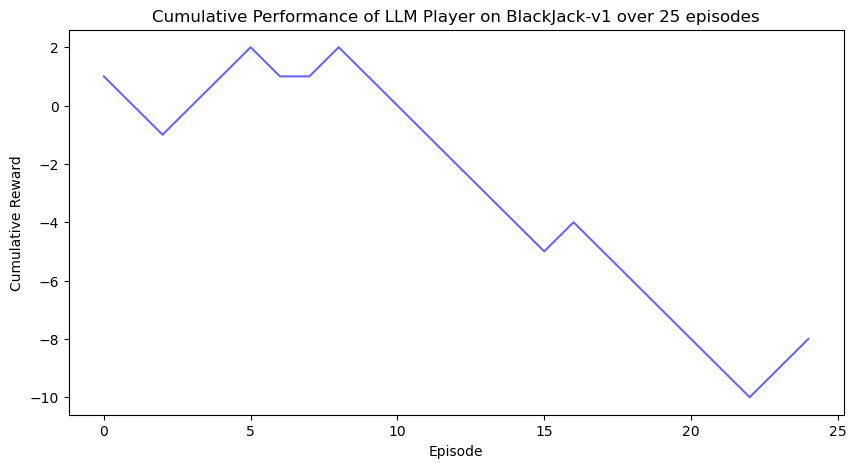

In [5]:
from tqdm import tqdm
def evaluate_llm_and_save_gif(num_episodes=100, filename="blackjack.gif"):
    """
    Evaluate a random policy, save the rendered outputs to a GIF, and return aggregated rewards.
    """
    frames = []
    rewards = []

    for episode in tqdm(range(num_episodes)):
        state = env.reset()
        completion = openai.ChatCompletion.create(
          model="local-model", # this field is currently unused
          messages=[
            {"role": "user", "content": generate_prompt(state, init=True)}
          ]
        )
        print(generate_prompt(state, init=True))
        action = extract_decision_llama2(completion.choices[0].message["content"])
        print("action:", action)
        
        episode_reward = 0
        done = False

        # Add initial state to frames
        frames.append(render_to_image(env))
        player_card=2

        while not done:
            
            # Take a step in the environment
            next_state, reward, done, _, info = env.step(action)
            if action==1:
                player_card+=1
            
            if not done:
                completion = openai.ChatCompletion.create(
              model="local-model", # this field is currently unused
              messages=[
                {"role": "user", "content": generate_prompt(next_state, player_cards_count=player_card)}
              ]
            )
                print(generate_prompt(next_state, player_cards_count=player_card))

            
                action = extract_decision_llama2(completion.choices[0].message["content"])
            
            print("action:", action)
            
            
            episode_reward += reward

            # Add the new state to frames
            frames.append(render_to_image(env))

        rewards.append(episode_reward)

    # Save frames as a gif
    imageio.mimsave(filename, [np.array(f) for f in frames], duration=0.5)
    print(f"GIF saved as {filename}")

    return rewards

num_episodes = 25
rewards = evaluate_llm_and_save_gif(num_episodes=num_episodes, filename="blackjackllm.gif")

# Calculate cumulative rewards
cumulative_rewards = np.cumsum(rewards)

# Plotting the cumulative rewards
plt.figure(figsize=(10, 5))
plt.plot(np.arange(num_episodes), cumulative_rewards, alpha=0.6, color='blue')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Performance of LLM Player on BlackJack-v1 over {} episodes'.format(num_episodes))
plt.show()
